##  Reproducing Genetic Alogrithm Generated CNC Cutting Parameters with a Neural Network

### Introducton

This notebook aims to reproduce the output data of *Multi-Objective Optimization of Turning Process during Machining of AlMg1SiCu (Aluminum) Using Non-Dominated Sorted Genetic Algorithm* by Rahul Dhabalea, VijayKumar S. Jattib, and T.P.Singhc. The study used a genetic algorithm (GA) to generate novel cutting parameters, and predict material removal rate & surface roughness. The study can be found [here](https://www.sciencedirect.com/science/article/pii/S2211812814005318) for further reading but some explanation will follow, mainly concerning the differences between goals and the methodology used in creating the artificial neural network (ANN).

### Background

The GA used twenty seven rows of input data that are a series of test cuts where a CNC machine tool was set to turn a constant diameter with a range of spindle speeds (rpm), feed rates (mm/rev), and depths of cut(mm). The results of each test cut take the form of a calculated material remove rate (mm$^3$/min) and surface roughness (μm) measurement. Their goal was to have the GA produce cutting conditions and results which maximized material removal rate and minimized surface roughness. These two outcomes are conflicting in nature and so result in one ideal output for each scenario. In total the GA generated and ranked sixteen suggestions. Five of the sixteen results were chosen for validation of the GA results and tested on the CNC mahcine. The results had an average of less than five percent error from the forcast. 

### This Notebook

The major difference between the study and this notebook, besides the algorithm used, is in the prediction method. The ANN will be designed to accept a desired material removal rate and surface roughness as inputs, and generate the spindle speed, feed rate, and depth of cut as outputs. The initial twenty seven rows will be used as training data, while the five rows used for validation in the study will be split into four rows of testing data and one row for validation. The single row kept for validation will have the lowest surface roughness value in the entire dataset. This makes for a more realistic test of the ANN because an end user would be requesting results that are better than the initial dataset and this input data will be outside anything the ANN has been trained on which makes for a more difficult prediction. 

### Details

Usually a dataset's features very widely between magnitude, units, and range. For this reason it's important to scale the data because most machine learning models recognize patterns using Eucledian distance between any two points. There are many ways to scale data but in this notebook two of the more common methods in the Scikit-Learn library will be applied separetly. Both scaled data sets will then be used with Talos to tune the hyperparameters of the neural network and the best results of each will be applied to the Keras model for final results on the validation data.


### Conclusion

This notebook was made to show the feasability in using a neaural network made with common open source tools to facilitate process improvements in manufacturing by replicating the successful results of a GA and adjusting the input and output parameters to create a tool useful for the shop floor.

Test cuts of this nature will likely produce a very samll amounts of data as seen in the study. Generally in machine learning a large amount of data is required for a robust model to be created, but it appears an acceptable level of accuracy is achievable with a limited dataset.

Other cutting or result data would likely need to be used to fit a real business model, for instance replacing material removal rate with some measure of process stability like tool life or "time since adjustment", but due to the proprietary nature of manufacturing the available data to develop tests with is limited.

In [567]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)





# import dependencies
%matplotlib inline
#import numpy as np
#np.random.seed(0)
import keras
from keras.models import Sequential
from keras.activations import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.layers import advanced_activations
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import seaborn as sns
import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import talos as ta
import warnings
warnings.filterwarnings("ignore")

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# suppress NumPy arrays scientific notation and round decimals to three places
np.set_printoptions(suppress=True)
np.printoptions(precision=3, suppress=True)

# print the version of each library being used
print('Dependency Version:\n')
print('Keras', keras.__version__)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', seaborn.__version__)
print('Sklearn', sklearn.__version__)
print('Talos', ta.__version__)

Dependency Version:

Keras 2.2.4
Numpy 1.15.0
Pandas 0.25.0
Seaborn 0.9.0
Sklearn 0.20.1
Talos 0.6.3


In [568]:
# import data
data = pd.read_csv('data.txt', delim_whitespace=True, encoding='ISO-8859-1')
# drop the index number of the tests
data.drop(columns=['Sr._No.'], inplace=True)

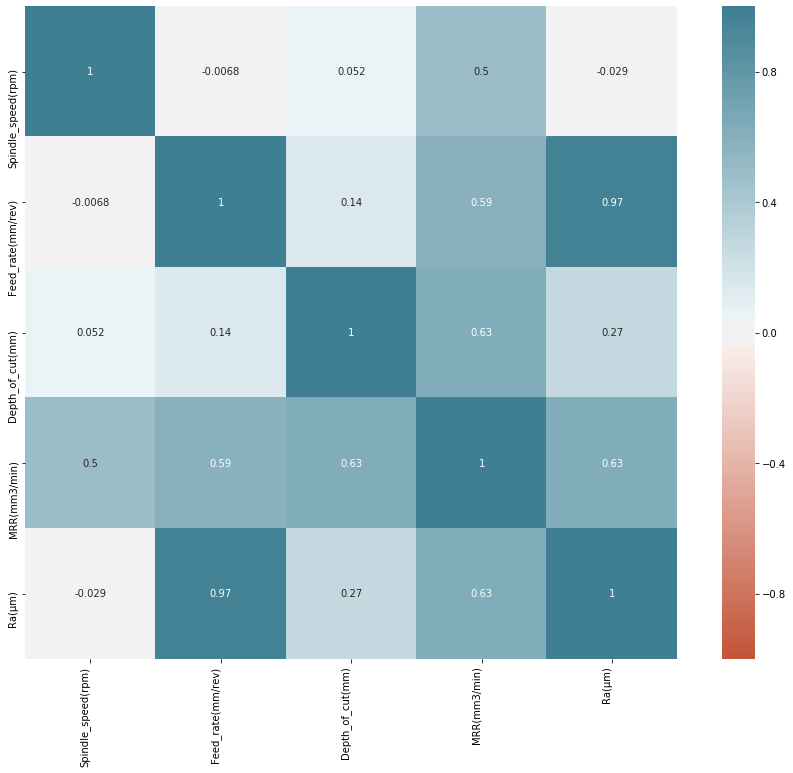

In [569]:
# a look at the overall correlation of each feature in the raw data
heat_data = data
plt.figure(figsize=(16, 12))
corr = heat_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);
plt.savefig('heatmap')

In [570]:
# change the dataframe into a NumPy array
np_data = data.values

In [571]:
# Transforms features by scaling each feature to a given range, -1 and 1 in this case
MinMax_scaler = MinMaxScaler(feature_range=(-1, 1))
np_data_MinMax = MinMax_scaler.fit_transform(np_data)

In [572]:
# Standardize features by removing the mean and scaling to unit variance
Standard_scaler = StandardScaler()
np_data_Standard = Standard_scaler.fit_transform(np_data)

In [573]:
# split the scaled MinMax data into training, testing, and validation sets
train_features_MinMax = np_data_MinMax[0:27 , 3:5]
test_features_MinMax = np_data_MinMax[28:32, 3:5]
validation_features_MinMax = np_data_MinMax[27, 3:5]
train_labels_MinMax = np_data_MinMax[0:27, 0:3]
test_labels_MinMax = np_data_MinMax[28:32, 0:3]
validation_labels_MinMax = np_data_MinMax[27, 0:3]

# reshape the validation data because it's only one row
validation_features_MinMax = validation_features_MinMax.reshape(1, -1)
validation_labels_MinMax = validation_labels_MinMax.reshape(1, -1)

In [574]:
# split the scaled Standard data into training, testing, and validation sets
train_features_Standard = np_data_Standard[0:27 , 3:5]
test_features_Standard = np_data_Standard[28:32, 3:5]
validation_features_Standard = np_data_Standard[27, 3:5]
train_labels_Standard = np_data_Standard[0:27, 0:3]
test_labels_Standard = np_data_Standard[28:32, 0:3]
validation_labels_Standard = np_data_Standard[27, 0:3]

# reshape the validation data because it's only one row
validation_features_Standard = validation_features_Standard.reshape(1, -1)
validation_labels_Standard = validation_labels_Standard.reshape(1, -1)

In [575]:
# combining original the testing group to compare against rescaled groups below
np_test_data = np.concatenate([np_data[28:32, 0:3], np_data[28:32, 3:5]], axis=1)
np_test_data

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [576]:
# combine the MinMax testing group and rescale
test_data_MinMax = np.concatenate([test_labels_MinMax, test_features_MinMax], axis=1)
MinMax_scaler.inverse_transform(test_data_MinMax)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [577]:
# combine the Standard testing group and rescale
test_data_Standard = np.concatenate([test_labels_Standard, test_features_Standard], axis=1)
Standard_scaler.inverse_transform(test_data_Standard)

array([[1100.  ,    0.05,    0.69, 2020.44,    0.29],
       [1095.  ,    0.15,    1.2 , 6054.12,    1.87],
       [1097.  ,    0.13,    1.14, 5329.21,    1.54],
       [1094.  ,    0.12,    1.15, 5197.29,    1.45]])

In [578]:
# parameters to try during Talos optimization

p = {
    'first_neuron': [8, 12],
    'second_neuron': [64, 76],
    'third_neuron': [64, 76],
    'fourth_neuron': [56, 64],
    'fifth_neuron': [48, 56],
    'sixth_neuron': [40, 48],
    'seventh_neuron': [32, 40],
    'eighth_neuron': [24, 32],
    'nineth_neuron': [16, 24],
    'tenth_neuron': [8, 16],
    'batch_size': [10, 20, 30],
    'activation': [relu,],  
                   #linear],
    'optimizer' : ['Adam',],
    'loss' : [mean_squared_error] 
}

In [579]:
# create a model for MinMax scaled data to use with Talos
def MinMax_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation='relu'))
    model.add(Dense(params['third_neuron'], activation='relu'))
    model.add(Dense(params['fourth_neuron'], activation='relu'))
    model.add(Dense(params['fifth_neuron'], activation='relu'))
    model.add(Dense(params['sixth_neuron'], activation='relu'))
    model.add(Dense(params['seventh_neuron'], activation='relu'))
    model.add(Dense(params['eighth_neuron'], activation='relu'))
    model.add(Dense(params['nineth_neuron'], activation='relu'))
    model.add(Dense(params['tenth_neuron'], activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_MinMax, train_labels_MinMax,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_MinMax, test_labels_MinMax])
    
    # model output
    return out, model

In [580]:
# create a model for Standard scaled data to use with Talos
def Standard_ann(train_features, train_labels, test_features, test_labels, params):
    
    # replace the hyperparameter inputs with references to params dictionary 
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=2, activation=params['activation']))
    model.add(Dense(params['second_neuron'], activation='relu'))
    model.add(Dense(params['third_neuron'], activation='relu'))
    model.add(Dense(params['fourth_neuron'], activation='relu'))
    model.add(Dense(params['fifth_neuron'], activation='relu'))
    model.add(Dense(params['sixth_neuron'], activation='relu'))
    model.add(Dense(params['seventh_neuron'], activation='relu'))
    model.add(Dense(params['eighth_neuron'], activation='relu'))
    model.add(Dense(params['nineth_neuron'], activation='relu'))
    model.add(Dense(params['tenth_neuron'], activation='relu'))
    model.add(Dense(3, activation='linear'))
    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    
    # make sure history object is returned by model.fit()
    out = model.fit(train_features_Standard, train_labels_Standard,
                    epochs=1000,
                    batch_size=params['batch_size'],
                    verbose=0,
                    validation_data=[test_features_Standard, test_labels_Standard])
    
    # model output
    return out, model

In [581]:
# combine MinMax training and test features, and training and test labels for Talos experiment
features_MinMax = np.concatenate((train_features_MinMax, test_features_MinMax), axis=0)
labels_MinMax = np.concatenate((train_labels_MinMax, test_labels_MinMax), axis=0)

In [582]:
# combine Standard training and test features, and training and test labels for Talos experiment
features_Standard = np.concatenate((train_features_Standard, test_features_Standard), axis=0)
labels_Standard = np.concatenate((train_labels_Standard, test_labels_Standard), axis=0)

https://rdrr.io/cran/kerasR/man/Initalizers.html

# run the Talos experiment on MinMax data and model
MinMax_t = ta.Scan(features_MinMax, labels_MinMax, 
            params=p, 
            model=MinMax_ann,
            experiment_name='MinMax',
            )

# run the Talos experiment on Standard data and model
Standard_t = ta.Scan(features_Standard, labels_Standard, 
            params=p, 
            model=Standard_ann,
            experiment_name='Standard'
            )

# load the results data
MinMax_reporting = pd.read_csv('MinMax\\082319183812.csv')
Standard_reporting = pd.read_csv('Standard\\082319191557.csv')

# sort by validation loss and accuracy and show to best result
MinMax_reporting.sort_values(['val_loss', 'val_acc'], ascending=[True, False], inplace=True)
MinMax_reporting.head(1)

# sort by validation loss and accuracy and show the best result
Standard_reporting.sort_values(['val_loss', 'val_acc'], ascending=[True, False], inplace=True)
Standard_reporting.head(1)

In [583]:
# Define the MinMax model using the top performing parameters from Talos
MinMax_model = Sequential()
MinMax_model.add(Dense(8, input_dim=2, activation='relu'))
MinMax_model.add(Dense(64, activation='relu'))
MinMax_model.add(Dense(64, activation='relu'))
MinMax_model.add(Dense(56, activation='relu'))
MinMax_model.add(Dense(48, activation='relu'))
MinMax_model.add(Dense(40, activation='relu'))
MinMax_model.add(Dense(32, activation='relu'))
MinMax_model.add(Dense(24, activation='relu'))
MinMax_model.add(Dense(16, activation='relu'))
MinMax_model.add(Dense(8, activation='relu'))
MinMax_model.add(Dense(3, activation='relu')) # softplus, softmax, selu, tanh, sigmoid, hard_sigmoid, exponential 
                                             #ok: softsign, elu, linear
MinMax_model.compile(loss='cosine_proximity', optimizer='adam', metrics=['accuracy'])
                          # logcosh, mean_squared_error, mean_absolute_percentage_error, mean_squared_logarithmic_error, squared_hinge, hinge, kullback_leibler_divergence
                          # mean_absolute_error, poisson

MinMax_model.fit(train_features_MinMax,
                 train_labels_MinMax,
                 validation_data=(test_features_MinMax, test_labels_MinMax),
                 batch_size=20,
                 epochs=1000)

Train on 27 samples, validate on 4 samples
Epoch 1/1000
27/27 [==============================] - 12s 443ms/step - loss: 0.0086 - acc: 0.2963 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 4/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 6/1000
27/27 [==============================] - 0s 4ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 7/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 

Epoch 60/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 61/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 62/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 63/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 64/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 65/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 66/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 67/1000
27/27 [======

27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 119/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 120/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 121/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 122/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 123/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 124/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 125/1000
27/27 [=============

27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 177/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 178/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 179/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 180/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 181/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 182/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 183/1000
27/27 [=============

27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 235/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 236/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 237/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 238/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 239/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 240/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 241/1000
27/27 [=============

27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 293/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 294/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 295/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 296/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 297/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 298/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 299/1000
27/27 [=============

27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 351/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 352/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 353/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 354/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 355/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 356/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 357/1000
27/27 [=============

27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 409/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 410/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 411/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 412/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 413/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 414/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 415/1000
27/27 [=============

27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 467/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 468/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 469/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 470/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 471/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 472/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 473/1000
27/27 [=============

27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 525/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 526/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 527/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 528/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 529/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 530/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 531/1000
27/27 [=============

27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 583/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 584/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 585/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 586/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 587/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 588/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.0152 - acc: 0.3333 - val_loss: -0.1350 - val_acc: 0.0000e+00
Epoch 589/1000
27/27 [=============

Epoch 641/1000
27/27 [==============================] - 0s 2ms/step - loss: 2.6215e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 642/1000
27/27 [==============================] - 0s 1ms/step - loss: -1.8213e-08 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 643/1000
27/27 [==============================] - 0s 2ms/step - loss: -3.8633e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 644/1000
27/27 [==============================] - 0s 2ms/step - loss: -8.0025e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 645/1000
27/27 [==============================] - 0s 2ms/step - loss: -9.1063e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 646/1000
27/27 [==============================] - 0s 1ms/step - loss: 6.6227e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 647/1000
27/27 [==============================] - 0s 2ms/step - loss: -5.5189e-10 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 648/1000
27/27 [

Epoch 700/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 701/1000
27/27 [==============================] - 0s 1ms/step - loss: 4.6911e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 702/1000
27/27 [==============================] - 0s 2ms/step - loss: 9.1063e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 703/1000
27/27 [==============================] - 0s 2ms/step - loss: -7.1746e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 704/1000
27/27 [==============================] - 0s 2ms/step - loss: -5.5189e-10 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 705/1000
27/27 [==============================] - 0s 1ms/step - loss: -1.6557e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 706/1000
27/27 [==============================] - 0s 2ms/step - loss: -6.6227e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 707/1000
27/27 [=

27/27 [==============================] - 0s 1ms/step - loss: -4.4152e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 759/1000
27/27 [==============================] - 0s 2ms/step - loss: 9.0373e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 760/1000
27/27 [==============================] - 0s 1ms/step - loss: 2.7595e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 761/1000
27/27 [==============================] - 0s 2ms/step - loss: -9.9341e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 762/1000
27/27 [==============================] - 0s 1ms/step - loss: -5.5189e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 763/1000
27/27 [==============================] - ETA: 0s - loss: -0.0706 - acc: 0.25 - 0s 1ms/step - loss: 1.1038e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 764/1000
27/27 [==============================] - 0s 1ms/step - loss: -7.7265e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500


27/27 [==============================] - 0s 2ms/step - loss: 1.1038e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 817/1000
27/27 [==============================] - ETA: 0s - loss: 0.0646 - acc: 0.200 - 0s 1ms/step - loss: 1.1590e-08 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 818/1000
27/27 [==============================] - 0s 1ms/step - loss: -1.1038e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 819/1000
27/27 [==============================] - 0s 2ms/step - loss: 9.1753e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 820/1000
27/27 [==============================] - 0s 1ms/step - loss: -6.6217e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 821/1000
27/27 [==============================] - 0s 2ms/step - loss: -1.6557e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 822/1000
27/27 [==============================] - 0s 1ms/step - loss: 1.2142e-08 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
E

27/27 [==============================] - 0s 2ms/step - loss: 3.3114e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 875/1000
27/27 [==============================] - 0s 1ms/step - loss: 1.6557e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 876/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.3468e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 877/1000
27/27 [==============================] - 0s 1ms/step - loss: -8.8303e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 878/1000
27/27 [==============================] - 0s 2ms/step - loss: -3.5873e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 879/1000
27/27 [==============================] - 0s 2ms/step - loss: -6.7607e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 880/1000
27/27 [==============================] - 0s 2ms/step - loss: 1.0486e-08 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 881/1000
27/27 [=================

Epoch 933/1000
27/27 [==============================] - 0s 1ms/step - loss: -2.7595e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 934/1000
27/27 [==============================] - 0s 2ms/step - loss: -5.5189e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 935/1000
27/27 [==============================] - 0s 1ms/step - loss: 3.3114e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 936/1000
27/27 [==============================] - 0s 2ms/step - loss: 3.3114e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 937/1000
27/27 [==============================] - 0s 1ms/step - loss: 4.4152e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 938/1000
27/27 [==============================] - 0s 2ms/step - loss: -4.4152e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 939/1000
27/27 [==============================] - 0s 1ms/step - loss: 5.5189e-10 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 940/1000
27/27 [==

Epoch 992/1000
27/27 [==============================] - 0s 2ms/step - loss: -3.8633e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 993/1000
27/27 [==============================] - 0s 1ms/step - loss: 6.8987e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 994/1000
27/27 [==============================] - 0s 2ms/step - loss: 6.6227e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 995/1000
27/27 [==============================] - 0s 1ms/step - loss: -4.4152e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 996/1000
27/27 [==============================] - 0s 2ms/step - loss: -5.5189e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 997/1000
27/27 [==============================] - 0s 2ms/step - loss: -7.1746e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 998/1000
27/27 [==============================] - 0s 1ms/step - loss: 1.3797e-09 - acc: 0.1852 - val_loss: -0.4176 - val_acc: 0.2500
Epoch 999/1000
27/27 [=

weights_list = MinMax_model.get_weights()
weights_list

In [584]:
# Define the Standard model using the top performing parameters from Talos
Standard_model = Sequential()
Standard_model.add(Dense(8, input_dim=2, activation='linear'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(64, activation='relu'))
Standard_model.add(Dense(56, activation='relu'))
Standard_model.add(Dense(48, activation='relu'))
Standard_model.add(Dense(40, activation='relu'))
Standard_model.add(Dense(32, activation='relu'))
Standard_model.add(Dense(24, activation='relu'))
Standard_model.add(Dense(16, activation='relu'))
Standard_model.add(Dense(8, activation='relu'))
Standard_model.add(Dense(3, activation='linear'))
Standard_model.compile(loss='cosine_proximity', optimizer='adam', metrics=['accuracy'])

Standard_model.fit(train_features_Standard,
                 train_labels_Standard,
                 validation_data=(test_features_Standard, test_labels_Standard),
                 batch_size=20,
                 epochs=1000)

Train on 27 samples, validate on 4 samples
Epoch 1/1000
27/27 [==============================] - 11s 409ms/step - loss: -0.0431 - acc: 0.3333 - val_loss: -0.3459 - val_acc: 0.5000
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.2154 - acc: 0.5556 - val_loss: -0.3942 - val_acc: 0.5000
Epoch 3/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.3611 - acc: 0.5926 - val_loss: -0.4200 - val_acc: 0.5000
Epoch 4/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.4668 - acc: 0.5185 - val_loss: -0.4523 - val_acc: 0.5000
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.5291 - acc: 0.5185 - val_loss: -0.5878 - val_acc: 0.5000
Epoch 6/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.5666 - acc: 0.5556 - val_loss: -0.6792 - val_acc: 0.5000
Epoch 7/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.5813 - acc: 0.5556 - val_loss: -0.6952 - val_acc: 0.5000
Epoch 8/1000
27/

27/27 [==============================] - 0s 2ms/step - loss: -0.7862 - acc: 0.7778 - val_loss: -0.7718 - val_acc: 0.7500
Epoch 62/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.8024 - acc: 0.7778 - val_loss: -0.7506 - val_acc: 0.7500
Epoch 63/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.8078 - acc: 0.7407 - val_loss: -0.7295 - val_acc: 0.7500
Epoch 64/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.8098 - acc: 0.7407 - val_loss: -0.7012 - val_acc: 0.7500
Epoch 65/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.8166 - acc: 0.7407 - val_loss: -0.6451 - val_acc: 0.7500
Epoch 66/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.7915 - acc: 0.7407 - val_loss: -0.7201 - val_acc: 0.7500
Epoch 67/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.8042 - acc: 0.7407 - val_loss: -0.8443 - val_acc: 1.0000
Epoch 68/1000
27/27 [==============================] - 0s 2ms/step - 

27/27 [==============================] - 0s 2ms/step - loss: -0.9350 - acc: 0.8519 - val_loss: -0.9030 - val_acc: 0.7500
Epoch 122/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9375 - acc: 0.7407 - val_loss: -0.9066 - val_acc: 0.7500
Epoch 123/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9382 - acc: 0.7407 - val_loss: -0.8842 - val_acc: 0.7500
Epoch 124/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9433 - acc: 0.7778 - val_loss: -0.9063 - val_acc: 0.7500
Epoch 125/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9472 - acc: 0.8519 - val_loss: -0.9607 - val_acc: 0.7500
Epoch 126/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9422 - acc: 0.8889 - val_loss: -0.9684 - val_acc: 0.7500
Epoch 127/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9447 - acc: 0.8519 - val_loss: -0.8958 - val_acc: 0.5000
Epoch 128/1000
27/27 [==============================] - 0s 1ms/

27/27 [==============================] - 0s 2ms/step - loss: -0.9645 - acc: 0.8148 - val_loss: -0.9203 - val_acc: 0.7500
Epoch 182/1000
27/27 [==============================] - 0s 926us/step - loss: -0.9560 - acc: 0.8519 - val_loss: -0.9090 - val_acc: 0.7500
Epoch 183/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9529 - acc: 0.8519 - val_loss: -0.8782 - val_acc: 0.7500
Epoch 184/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9656 - acc: 0.8889 - val_loss: -0.8644 - val_acc: 0.7500
Epoch 185/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9657 - acc: 0.8889 - val_loss: -0.8841 - val_acc: 0.7500
Epoch 186/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9700 - acc: 0.8148 - val_loss: -0.8597 - val_acc: 0.7500
Epoch 187/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9662 - acc: 0.8148 - val_loss: -0.8035 - val_acc: 0.7500
Epoch 188/1000
27/27 [==============================] - 0s 1m

27/27 [==============================] - 0s 2ms/step - loss: -0.9747 - acc: 0.8148 - val_loss: -0.8164 - val_acc: 0.7500
Epoch 242/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9756 - acc: 0.8519 - val_loss: -0.8190 - val_acc: 0.7500
Epoch 243/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9764 - acc: 0.7778 - val_loss: -0.8090 - val_acc: 0.7500
Epoch 244/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9703 - acc: 0.7778 - val_loss: -0.8107 - val_acc: 0.7500
Epoch 245/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9779 - acc: 0.8148 - val_loss: -0.8280 - val_acc: 0.7500
Epoch 246/1000
27/27 [==============================] - 0s 3ms/step - loss: -0.9714 - acc: 0.8889 - val_loss: -0.8889 - val_acc: 0.7500
Epoch 247/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9809 - acc: 0.8519 - val_loss: -0.9074 - val_acc: 0.7500
Epoch 248/1000
27/27 [==============================] - 0s 2ms/

Epoch 301/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9906 - acc: 0.8889 - val_loss: -0.8930 - val_acc: 0.7500
Epoch 302/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9905 - acc: 0.8148 - val_loss: -0.8903 - val_acc: 0.7500
Epoch 303/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9924 - acc: 0.8148 - val_loss: -0.8692 - val_acc: 0.7500
Epoch 304/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9886 - acc: 0.8889 - val_loss: -0.8996 - val_acc: 0.7500
Epoch 305/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9921 - acc: 0.9630 - val_loss: -0.9082 - val_acc: 0.7500
Epoch 306/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9893 - acc: 0.8519 - val_loss: -0.8797 - val_acc: 0.7500
Epoch 307/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9926 - acc: 0.8889 - val_loss: -0.8607 - val_acc: 0.7500
Epoch 308/1000
27/27 [==========================

27/27 [==============================] - 0s 2ms/step - loss: -0.9847 - acc: 0.8889 - val_loss: -0.8140 - val_acc: 1.0000
Epoch 361/1000
27/27 [==============================] - ETA: 0s - loss: -0.9828 - acc: 0.85 - 0s 1ms/step - loss: -0.9821 - acc: 0.8519 - val_loss: -0.8561 - val_acc: 0.7500
Epoch 362/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9863 - acc: 0.8889 - val_loss: -0.9101 - val_acc: 0.7500
Epoch 363/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9870 - acc: 0.7407 - val_loss: -0.9512 - val_acc: 0.7500
Epoch 364/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9818 - acc: 0.7778 - val_loss: -0.9540 - val_acc: 0.7500
Epoch 365/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9880 - acc: 0.7778 - val_loss: -0.9240 - val_acc: 0.7500
Epoch 366/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9894 - acc: 0.9259 - val_loss: -0.8957 - val_acc: 0.7500
Epoch 367/1000
27/27 [===

27/27 [==============================] - 0s 1ms/step - loss: -0.9943 - acc: 0.9630 - val_loss: -0.8838 - val_acc: 0.7500
Epoch 421/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9941 - acc: 0.8889 - val_loss: -0.8894 - val_acc: 0.7500
Epoch 422/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9972 - acc: 0.9259 - val_loss: -0.8899 - val_acc: 0.7500
Epoch 423/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9941 - acc: 0.9630 - val_loss: -0.8909 - val_acc: 0.7500
Epoch 424/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9969 - acc: 0.9259 - val_loss: -0.8964 - val_acc: 0.7500
Epoch 425/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9943 - acc: 0.8519 - val_loss: -0.8755 - val_acc: 0.7500
Epoch 426/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9959 - acc: 0.9259 - val_loss: -0.8682 - val_acc: 0.7500
Epoch 427/1000
27/27 [==============================] - 0s 2ms/

27/27 [==============================] - 0s 2ms/step - loss: -0.9981 - acc: 0.9630 - val_loss: -0.8884 - val_acc: 0.7500
Epoch 480/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9951 - acc: 0.8519 - val_loss: -0.8977 - val_acc: 0.7500
Epoch 481/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9964 - acc: 0.9259 - val_loss: -0.8983 - val_acc: 0.7500
Epoch 482/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9948 - acc: 0.9630 - val_loss: -0.8865 - val_acc: 0.7500
Epoch 483/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9972 - acc: 0.8889 - val_loss: -0.8985 - val_acc: 0.7500
Epoch 484/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9949 - acc: 0.8889 - val_loss: -0.8867 - val_acc: 0.7500
Epoch 485/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9972 - acc: 0.9259 - val_loss: -0.8686 - val_acc: 0.7500
Epoch 486/1000
27/27 [==============================] - 0s 1ms/

27/27 [==============================] - 0s 3ms/step - loss: -0.9990 - acc: 1.0000 - val_loss: -0.9100 - val_acc: 0.7500
Epoch 540/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9980 - acc: 0.8889 - val_loss: -0.9183 - val_acc: 0.7500
Epoch 541/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9988 - acc: 0.9259 - val_loss: -0.9145 - val_acc: 0.7500
Epoch 542/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9985 - acc: 0.9630 - val_loss: -0.9091 - val_acc: 0.7500
Epoch 543/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9988 - acc: 0.9259 - val_loss: -0.9151 - val_acc: 0.7500
Epoch 544/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9991 - acc: 1.0000 - val_loss: -0.9209 - val_acc: 0.7500
Epoch 545/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9992 - acc: 1.0000 - val_loss: -0.9144 - val_acc: 0.7500
Epoch 546/1000
27/27 [==============================] - 0s 1ms/

27/27 [==============================] - 0s 1ms/step - loss: -0.9997 - acc: 1.0000 - val_loss: -0.9160 - val_acc: 0.7500
Epoch 600/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9996 - acc: 1.0000 - val_loss: -0.9157 - val_acc: 0.7500
Epoch 601/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9997 - acc: 1.0000 - val_loss: -0.9141 - val_acc: 0.7500
Epoch 602/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9994 - acc: 1.0000 - val_loss: -0.9150 - val_acc: 0.7500
Epoch 603/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9995 - acc: 0.9630 - val_loss: -0.9172 - val_acc: 0.7500
Epoch 604/1000
27/27 [==============================] - 0s 4ms/step - loss: -0.9994 - acc: 1.0000 - val_loss: -0.9172 - val_acc: 0.7500
Epoch 605/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9994 - acc: 1.0000 - val_loss: -0.9155 - val_acc: 0.7500
Epoch 606/1000
27/27 [==============================] - 0s 2ms/

27/27 [==============================] - 0s 1ms/step - loss: -0.9986 - acc: 0.9259 - val_loss: -0.9145 - val_acc: 0.7500
Epoch 660/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9981 - acc: 0.8148 - val_loss: -0.9139 - val_acc: 0.7500
Epoch 661/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9988 - acc: 1.0000 - val_loss: -0.9164 - val_acc: 0.7500
Epoch 662/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9985 - acc: 1.0000 - val_loss: -0.9168 - val_acc: 0.7500
Epoch 663/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9990 - acc: 1.0000 - val_loss: -0.9041 - val_acc: 0.7500
Epoch 664/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9979 - acc: 0.9259 - val_loss: -0.9015 - val_acc: 0.7500
Epoch 665/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9989 - acc: 1.0000 - val_loss: -0.9066 - val_acc: 0.7500
Epoch 666/1000
27/27 [==============================] - 0s 2ms/

27/27 [==============================] - 0s 2ms/step - loss: -0.9976 - acc: 1.0000 - val_loss: -0.8981 - val_acc: 0.7500
Epoch 720/1000
27/27 [==============================] - 0s 3ms/step - loss: -0.9984 - acc: 0.9630 - val_loss: -0.9082 - val_acc: 0.7500
Epoch 721/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9982 - acc: 0.9259 - val_loss: -0.9124 - val_acc: 0.7500
Epoch 722/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9979 - acc: 1.0000 - val_loss: -0.9158 - val_acc: 0.7500
Epoch 723/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9982 - acc: 1.0000 - val_loss: -0.9143 - val_acc: 0.7500
Epoch 724/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9989 - acc: 1.0000 - val_loss: -0.9116 - val_acc: 0.7500
Epoch 725/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9978 - acc: 0.9630 - val_loss: -0.9074 - val_acc: 0.7500
Epoch 726/1000
27/27 [==============================] - 0s 2ms/

27/27 [==============================] - 0s 2ms/step - loss: -0.9992 - acc: 0.9630 - val_loss: -0.9122 - val_acc: 0.7500
Epoch 780/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9973 - acc: 0.9630 - val_loss: -0.9158 - val_acc: 0.7500
Epoch 781/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9992 - acc: 1.0000 - val_loss: -0.9061 - val_acc: 0.7500
Epoch 782/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9987 - acc: 0.9259 - val_loss: -0.9036 - val_acc: 0.7500
Epoch 783/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9995 - acc: 1.0000 - val_loss: -0.9058 - val_acc: 0.7500
Epoch 784/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9985 - acc: 1.0000 - val_loss: -0.9050 - val_acc: 0.7500
Epoch 785/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9991 - acc: 1.0000 - val_loss: -0.9068 - val_acc: 0.7500
Epoch 786/1000
27/27 [==============================] - 0s 2ms/

27/27 [==============================] - 0s 2ms/step - loss: -0.9999 - acc: 1.0000 - val_loss: -0.9068 - val_acc: 0.7500
Epoch 840/1000
27/27 [==============================] - 0s 3ms/step - loss: -0.9999 - acc: 1.0000 - val_loss: -0.9067 - val_acc: 0.7500
Epoch 841/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9998 - acc: 1.0000 - val_loss: -0.9085 - val_acc: 0.7500
Epoch 842/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9999 - acc: 1.0000 - val_loss: -0.9102 - val_acc: 0.7500
Epoch 843/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9997 - acc: 1.0000 - val_loss: -0.9067 - val_acc: 0.7500
Epoch 844/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9999 - acc: 1.0000 - val_loss: -0.9037 - val_acc: 0.7500
Epoch 845/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9997 - acc: 0.9630 - val_loss: -0.9074 - val_acc: 0.7500
Epoch 846/1000
27/27 [==============================] - 0s 2ms/

27/27 [==============================] - 0s 2ms/step - loss: -0.9986 - acc: 1.0000 - val_loss: -0.8773 - val_acc: 0.7500
Epoch 900/1000
27/27 [==============================] - 0s 1ms/step - loss: -0.9964 - acc: 0.9259 - val_loss: -0.8951 - val_acc: 0.7500
Epoch 901/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9983 - acc: 0.9259 - val_loss: -0.9111 - val_acc: 0.7500
Epoch 902/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9971 - acc: 0.8889 - val_loss: -0.8988 - val_acc: 0.7500
Epoch 903/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9978 - acc: 0.9630 - val_loss: -0.8977 - val_acc: 0.7500
Epoch 904/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9991 - acc: 0.9259 - val_loss: -0.9052 - val_acc: 0.7500
Epoch 905/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9986 - acc: 0.9259 - val_loss: -0.9132 - val_acc: 0.7500
Epoch 906/1000
27/27 [==============================] - 0s 2ms/

27/27 [==============================] - 0s 2ms/step - loss: -0.9995 - acc: 0.9630 - val_loss: -0.9047 - val_acc: 0.7500
Epoch 960/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9996 - acc: 0.9630 - val_loss: -0.9011 - val_acc: 0.7500
Epoch 961/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9995 - acc: 1.0000 - val_loss: -0.9091 - val_acc: 0.7500
Epoch 962/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9994 - acc: 1.0000 - val_loss: -0.9130 - val_acc: 0.7500
Epoch 963/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9997 - acc: 1.0000 - val_loss: -0.9052 - val_acc: 0.7500
Epoch 964/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9997 - acc: 1.0000 - val_loss: -0.9017 - val_acc: 0.7500
Epoch 965/1000
27/27 [==============================] - 0s 2ms/step - loss: -0.9995 - acc: 0.9630 - val_loss: -0.9045 - val_acc: 0.7500
Epoch 966/1000
27/27 [==============================] - 0s 2ms/

In [585]:
# MinMax prediction on validation data
prediction = MinMax_model.predict(validation_features_MinMax)
validation_prediction = np.concatenate([prediction, validation_features_MinMax], axis=1)
validation = MinMax_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('MinMax Validation Prediction:\n\n', validation)
print('\nActual Validation:\n\n', np_data[27, 0:3])

MinMax Validation Prediction:

 [[700.           0.1012       0.97583681]]

Actual Validation:

 [1100.      0.05    0.4 ]


In [586]:
MinMax_rpm_error = ((np_data[27, 0:3][0] - validation[0][0])/np_data[27, 0:3][0])*100
MinMax_feed_error = ((np_data[27, 0:3][1] - validation[0][1])/np_data[27, 0:3][1])*100
MinMax_doc_error = ((np_data[27, 0:3][2] - validation[0][2])/np_data[27, 0:3][2])*100
MinMax_average_error = (np.absolute(MinMax_rpm_error) + np.absolute(MinMax_feed_error) + np.absolute(MinMax_doc_error)) / 3

print('MinMax percent errors:\n')
print('RPM : ', MinMax_rpm_error)
print('Feedrate : ', MinMax_feed_error)
print('Depth of cut : ', MinMax_doc_error)
print('Average : ', MinMax_average_error)

MinMax percent errors:

RPM :  36.36363636363637
Feedrate :  -102.39999999999998
Depth of cut :  -143.95920336246488
Average :  94.24094657536709


In [587]:
# Standard prediction on validation
prediction = Standard_model.predict(validation_features_Standard)
validation_prediction = np.concatenate([prediction, validation_features_Standard], axis=1)
validation = Standard_scaler.inverse_transform(validation_prediction)[:, 0:3]
# compare
print('Standard Validation Prediction:\n\n', validation[0])
print('\nActual Validation:\n\n', np_data[27, 0:3])

Standard Validation Prediction:

 [770.30827669   0.10098938   0.81447033]

Actual Validation:

 [1100.      0.05    0.4 ]


In [588]:
Standard_rpm_error = ((np_data[27, 0:3][0] - validation[0][0])/np_data[27, 0:3][0])*100
Standard_feed_error = ((np_data[27, 0:3][1] - validation[0][1])/np_data[27, 0:3][1])*100
Standard_doc_error = ((np_data[27, 0:3][2] - validation[0][2])/np_data[27, 0:3][2])*100
Standard_average_error = (np.absolute(Standard_rpm_error) + np.absolute(Standard_feed_error) + np.absolute(Standard_doc_error)) / 3

print('Standard percent errors:\n')
print('RPM : ', Standard_rpm_error)
print('Feed rate : ', Standard_feed_error)
print('Depth of cut : ', Standard_doc_error)
print('Average : ', Standard_average_error)

Standard percent errors:

RPM :  29.971974846605733
Feed rate :  -101.97876044735649
Depth of cut :  -103.61758266500966
Average :  78.52277265299062
